In [6]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import models
import torch.nn.functional as nnf
import torch.nn as nn


from utils.metrics import validation_scores
from models.completion.AE import AE
from utils.datasets import MNIST_SR_completion


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
num_epochs = 10
batch_size = 512
scalefactor = 2
latent_dims = [64]
channels = [32, 64, 128, 256]
in_channels = 1
base_width = 16
model = AE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, base_width, base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, base_width, base_width), (1, in_channels, 32, 32)])

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 1, 32, 32]            --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           64
│    └─Conv2d: 2-2                       [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-3                       [1, 128, 4, 4]            131,200
│    └─Linear: 2-4                       [1, 64]                   131,136
├─AEDecoder: 1-2                         [1, 1, 32, 32]            --
│    └─Linear: 2-5                       [1, 4096]                 266,240
│    └─ConvTranspose2d: 2-6              [1, 128, 8, 8]            524,416
│    └─ConvTranspose2d: 2-7              [1, 64, 16, 16]           131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 32, 32]           32,800
│    └─Conv2d: 2-9                       [1, 1, 32, 32]            33
Total params: 1,249,857
Trainable params: 1,249,857


In [8]:
train_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='train')
test_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 60000 training samples, 10000 validation samples


In [9]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-4)
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(pretrained=True).features[:16]
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG weights
        self.vgg = vgg

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return nnf.mse_loss(pred_features, target_features)  # Feature-level loss
perceptual_loss = PerceptualLoss().to(device)
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [10]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0


    for HR, LR, LR_UP in train_loader:

        optimizer.zero_grad()

        recon_imgs = model(LR, LR_UP)
        recon_imgs = recon_imgs.repeat(1, 3, 1, 1)
        HR = HR.repeat(1, 3, 1, 1)
        loss = perceptual_loss(recon_imgs, HR)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f}")
    model.loss.append(total_loss)


Epoch [1/10] | Loss: 122.45
Epoch [2/10] | Loss: 101.59
Epoch [3/10] | Loss: 82.16
Epoch [4/10] | Loss: 65.65
Epoch [5/10] | Loss: 57.07
Epoch [6/10] | Loss: 52.30
Epoch [7/10] | Loss: 48.86
Epoch [8/10] | Loss: 46.13
Epoch [9/10] | Loss: 43.90
Epoch [10/10] | Loss: 42.02


[]

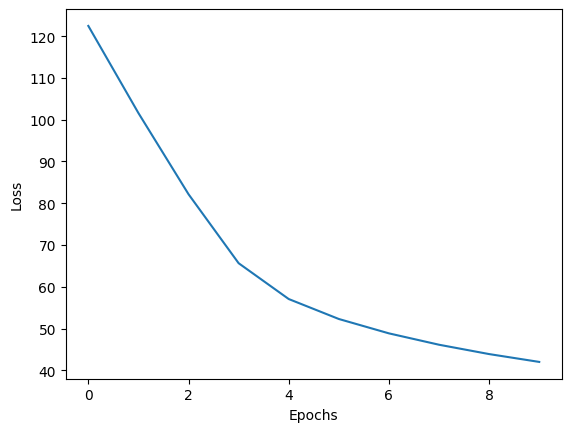

In [11]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [12]:
HR, LR, LR_UP = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [13]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(4, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')
            axs[3, i].set_title('Low Resolution Upscaled')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

        axs[3, i].imshow(LR_UP[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[3, i].axis('off')

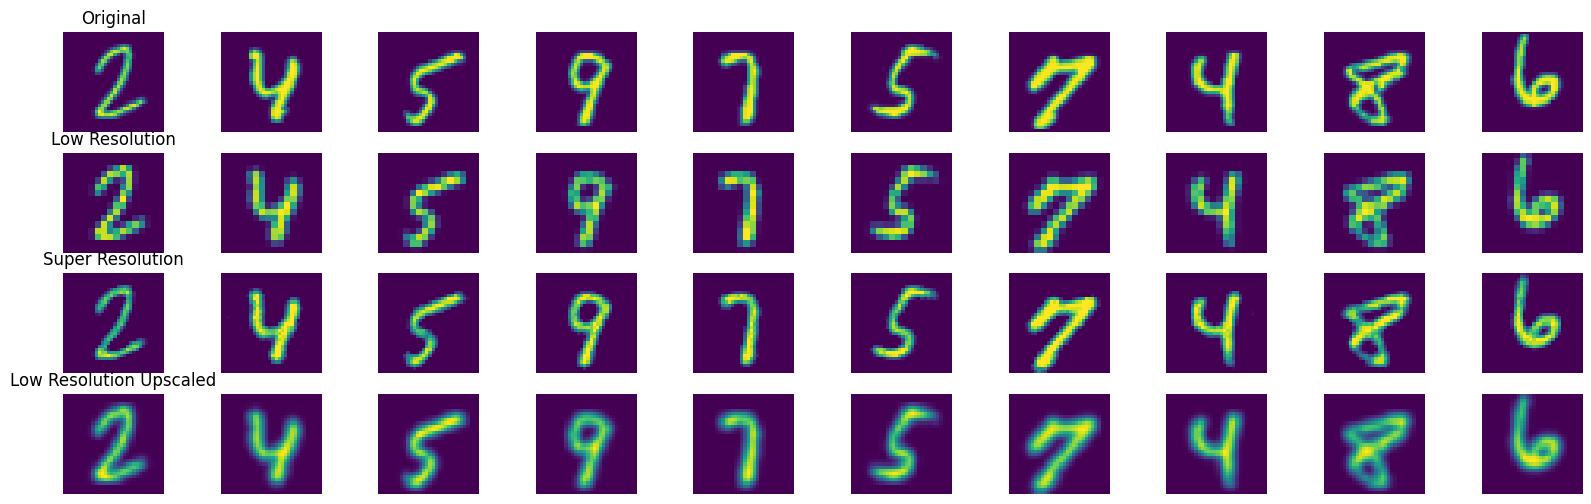

In [14]:
show_image(HR, LR, SR, 10)

In [15]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: 26.72564697265625
SSIM: 0.9633103609085083
LPIPS: 0.02038813754916191
BRISQUE: 76.38178253173828
PSNR Consistency: 33.58986282348633
MSE Diversity: 4.615159598277542e-17
LPIPS Diversity: 4.665465131501562e-12
